Get 3 options with historical information and different ATM-ITM Strike prices. From each stock: 

In [1]:
import re
import datetime as dt 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from IPython.display import display
from tqdm import tqdm
import sqlite3 as sql 
from scipy.optimize import minimize
import scipy.stats as st 
%matplotlib inline

db_path = '../data/options-data.db'
conn = sql.connect(db_path)
c = conn.cursor()
# Get stocks (table names in db)
stocks = [x[0] for x in c.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()]
# Create dict of dataframes
lod = {}
for stock in stocks:
    lod[stock] = pd.read_sql(f'select * from {stock}', conn, parse_dates = ['gatherdate', 'expiry'])

def close_to_the_money(stock):
    df = lod[stock].copy()
    df['days_to_expiry'] = np.maximum((df['expiry'] - df['gatherdate']).dt.days, 0)
    # #contracts = df.drop(columns = ['expiry', 'strike', 'type']).set_index(['contractsymbol', 'gatherdate']).sort_index().copy()
    contracts = df.set_index(['contractsymbol', 'gatherdate']).sort_index().copy()
    
    # # keep contracts that have atleast 50 entries 
    contracts = contracts.groupby('contractsymbol').filter(lambda x: len(x) > 50)

    # get close to the money strikes, based on the mean. 
    ad = contracts.stk_price.tail(20).drop_duplicates().describe()
    adr = ad['mean'] - 2*ad['std'], ad['mean'] + 2*ad['std']
    contracts = contracts[contracts.strike.between(*adr)]

    return contracts



We obtained historical data from Yahoo Finance for three major indicies to track overall movments in the stock market. The data was obtained over the past year, at a random point in time each day. Some days there are more data points than others, so we will use the latest collected data point for each day.

The stocks are the SPDR S&P 500 ETF (SPY), Invesco QQQ Trust (QQQ), and the iShares Russel 2000 (IWM). The options on these stocks are traded heavily by investors, therefore there is a huge interest in pricing these particular options. 

We decided to narrow our to the expiration date of 3/17/23. For this expiration, we have over 150+ data points for each contract. 


In [2]:
t = lod['spy'].copy()
t[t['contractsymbol'] == 'SPY230317P00398000']

,gatherdate,contractsymbol,type,expiry,strike,stk_price,impliedvolatility,lastprice,ask,bid,timevalue,inthemoney
38333,2022-07-22 00:00:00,SPY230317P00398000,Put,2023-03-17,398.0,393.06,0.217842,27.70,30.31,29.76,0.944444,1
38600,2022-07-25 00:00:00,SPY230317P00398000,Put,2023-03-17,398.0,394.28,0.218605,29.96,29.61,29.25,0.932540,1
38867,2022-07-26 00:00:00,SPY230317P00398000,Put,2023-03-17,398.0,391.40,0.216210,29.96,30.66,30.25,0.928571,1
39134,2022-07-27 00:00:00,SPY230317P00398000,Put,2023-03-17,398.0,401.04,0.222267,27.90,26.76,26.33,0.924603,0
39401,2022-07-28 00:00:00,SPY230317P00398000,Put,2023-03-17,398.0,406.23,0.220436,27.90,24.26,23.99,0.920635,0
...,...,...,...,...,...,...,...,...,...,...,...,...
158767,2023-03-17 10:02:16,SPY230317P00398000,Put,2023-03-17,398.0,393.83,0.352546,5.50,5.48,5.33,-0.001660,1
159234,2023-03-17 12:44:33,SPY230317P00398000,Put,2023-03-17,398.0,390.67,0.243172,7.92,7.49,7.29,-0.002107,1
159701,2023-03-17 14:32:15,SPY230317P00398000,Put,2023-03-17,398.0,389.33,0.000010,8.28,8.39,8.21,-0.002404,1
160168,2023-03-17 15:50:57,SPY230317P00398000,Put,2023-03-17,398.0,389.86,0.000010,8.24,8.08,7.96,-0.002621,1


In [71]:
contract_keeps = {}
for x in stocks:
    tmp = close_to_the_money(x)
    conts = list(tmp.index.get_level_values(0).unique())
    dtf = pd.DataFrame()
    keeps = []
    for i in conts: 
        d = tmp.loc[i].copy()
        otm_cnt = d[d.stk_price > d.strike].shape[0]
        itm_cnt = d[d.stk_price < d.strike].shape[0]
        if otm_cnt != 0 and itm_cnt != 0:
            rat = itm_cnt/ (otm_cnt + itm_cnt)
            if rat > .4 and rat < .8:
                dtf = dtf.append(pd.DataFrame({
                    'cont': i,
                    'obsv': otm_cnt + itm_cnt,
                    'otm_cnt': otm_cnt, 
                    'itm_cnt': itm_cnt, 
                    'itm_pct': rat
                }, index = [0]))
        
    tmp_dtf = dtf.sort_values('itm_pct', ascending = False).drop_duplicates().head(2)
    contract_keeps[x] = list(tmp_dtf.cont)

for i in contract_keeps:
    print(i, ':', contract_keeps[i])
lodf_keep = []
ck = []
for i in contract_keeps:
    t = lod[i].copy()
    t.insert(0, 'stock', i)
    for j in contract_keeps[i]:
        lodf_keep.append(t[t['contractsymbol'] == j])
        ck.append(j)


df_keep = pd.concat(lodf_keep)
#df_keep['days_to_expiry'] = df_keep['expiry'] - df_keep['gatherdate']).dt.days
df_keep.gatherdate = pd.to_datetime(df_keep.gatherdate)
df_keep.expiry = pd.to_datetime(df_keep.expiry)
df_keep.expiry = [x.replace(hour = 16, minute = 0, second = 0) for x in df_keep.expiry]
df_keep['days_to_expiry'] = (df_keep['expiry'] - df_keep['gatherdate']).dt.days
# change -1 days to expiry to 0
df_keep.loc[df_keep.days_to_expiry == -1, 'days_to_expiry'] = 0
df_keep.inthemoney = df_keep.inthemoney.replace({'True': 1,'1.0': 1, '0.0':0 ,'False': 0}).astype(int)
df_keep = df_keep.groupby(['contractsymbol','gatherdate']).last().reset_index()
#df_keep.gatherdate = [str(x)[:10] for x in df_keep.gatherdate]
assert len(ck) == len(df_keep.contractsymbol.unique())
# change all day_to_expiry to 0 if it is 1 
#df_keep.loc[df_keep.days_to_expiry == 1, 'days_to_expiry'] = 0

df_keep.to_csv('../data/data_final_set.csv', index = False)


spy : ['SPY230317C00398000', 'SPY230317P00398000']
qqq : ['QQQ230317C00304000', 'QQQ230317P00305000']
iwm : ['IWM230317C00185000', 'IWM230317P00185000']


In [65]:
# convert all dates in df_keep.expiry to have the end time of 16:00:00



0      2023-03-17 16:00:00
1      2023-03-17 16:00:00
2      2023-03-17 16:00:00
3      2023-03-17 16:00:00
4      2023-03-17 16:00:00
               ...        
1635   2023-03-17 16:00:00
1636   2023-03-17 16:00:00
1637   2023-03-17 16:00:00
1638   2023-03-17 16:00:00
1639   2023-03-17 16:00:00
Name: expiry, Length: 1640, dtype: datetime64[ns]

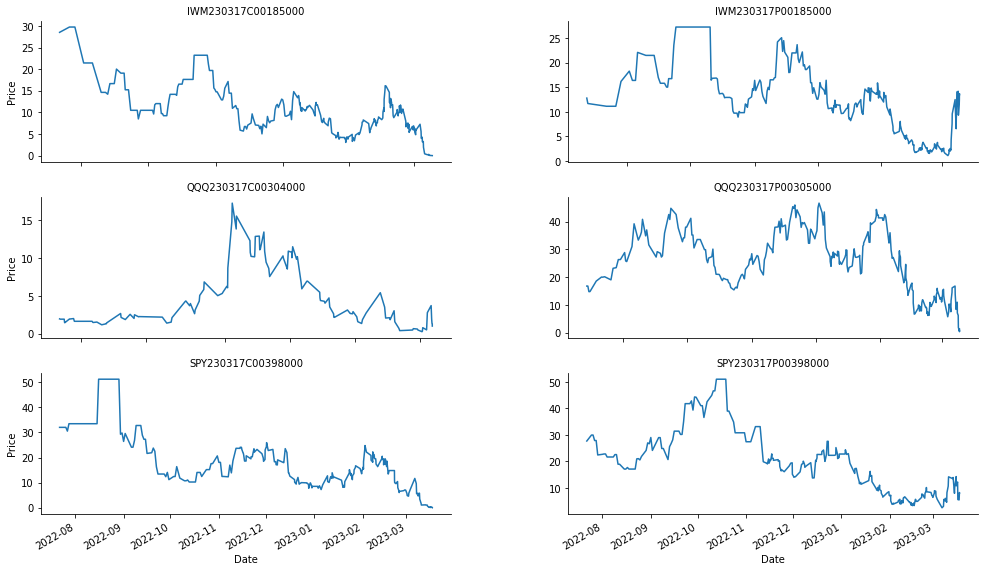

In [38]:
import seaborn as sns
# create a facet grid for each contract 
g= sns.FacetGrid(df_keep, col='contractsymbol',col_wrap=2,sharex=False,sharey=False)
g.map_dataframe(sns.lineplot, x='gatherdate',y='lastprice',hue='contractsymbol')
g.set_axis_labels('Date', 'Price')
g.set_titles('{col_name}')
g.fig.set_figwidth(15)
g.fig.autofmt_xdate()
plt.show()

In [35]:
import yfinance as yf 
#df_keep.gatherdate = df_keep.gatherdate.dt.date

ten_year = yf.Ticker('^TNX')
ten_year = ten_year.history(period = 'max')[['Close']]
ten_year = ten_year["2022-03-23":"2023-03-17"]
ten_year = ten_year.reset_index()
ten_year['Date'] = pd.to_datetime(ten_year['Date'])
ten_year = ten_year.rename(columns = {'Close': 'rf'})
ten_year['rf'] = ten_year['rf']/100
ten_year.to_csv('../data/ten_year.csv', index = False)